In [1]:
from sirf.Gadgetron import AcquisitionData, CoilSensitivityData, AcquisitionModel, ImageData
import numpy as np
import sys
sys.path.append("/home/jovyan/P1-Temp-Reg/modelbased-approach/")
import numpybased_auxiliary as aux
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import LinearOperator

In [2]:
dat = np.load("/home/jovyan/data_as_matrices.npz")

y = dat["y"]
mask = dat["mask"]

A = aux.A(mask)
u = np.zeros(y.shape, dtype=y.dtype)

In [3]:
beta_1 = 0.1
beta_2 = 0.1

In [4]:
class LHS():
    def __init__(self, template_shape, beta_x, beta_t,A,Dx,Dt):
        self.template_shape = template_shape
        self.beta_x = beta_x
        self.beta_t = beta_t
        self.A = A
        self.Dx = Dx
        self.Dt = Dt
    
    def forward(self,u):
        b = np.reshape(u,self.template_shape)
        return self.Left_hand_side(b)
        
    def Left_hand_side(self, u):

        first_part = self.A.backward(self.A.forward(u))
        second_part = self.beta_t*self.Dt.backward(self.Dt.backward(u))
        third_part = self.beta_x * self.Dx.backward(self.Dx.forward(u))
        return (first_part + second_part + third_part).flatten()


In [5]:
def Right_hand_side(y,mu_x, mu_t, z_x, z_t, beta_x,beta_t, A,Dx,Dt):
    return (A.backward(y) - Dx.backward(mu_x)- Dt.backward(mu_t)
            + beta_t*Dt.backward(z_t) + beta_x*Dx.backward(z_x))
        

In [6]:
def compute_init_u(y,A):
    return A.backward(y)

In [7]:
def solve_u_step(u_k,zt_k,zx_k,beta_x,beta_t,mut_k,mux_k, y,A,Dx,Dt):
    lhs = LHS(u_k.shape, beta_x, beta_t,A,Dx,Dt)
    operator_shape= (u_k.size, u_k.size)
    RHS = Right_hand_side(y,mux_k, mut_k, zx_k, zt_k,beta_x,beta_t, A,Dx,Dt)
    Operator = LinearOperator( operator_shape, matvec=lhs.forward )
    
    u_next = bicgstab(Operator, RHS.flatten(), u_k.flatten())
    return u_next[0].reshape(u_k.shape)
    

In [8]:
u_k = compute_init_u(y,A)
print(u_k.shape)

(128, 128, 12)


In [9]:
#B = LinearOperator((2,2), matvec=LHS)
u_k = compute_init_u(y,A)
Dx = aux.Dx()
Dt = aux.Dt()
zt_k = Dt.forward(u_k)
zx_k = Dx.forward(u_k)

zt_k[:] = 0
zx_k[0][:] = 0
zx_k[1][:] = 0

mut_k = zt_k
mut_k[:] = 0
mux_k = (mut_k, mut_k)

In [10]:
import time
tstart = time.time()
result = solve_u_step(u_k,zt_k,zx_k,beta_1,beta_2,mut_k,mux_k, y,A,Dx,Dt)
print(time.time()-tstart)

17.793096780776978


Text(0.5, 1.0, 'end')

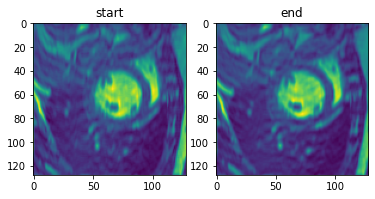

In [11]:
resimg = np.reshape(result, (128,128,12))
import matplotlib.pyplot as plt

plotframe = 6
f,ax = plt.subplots(1,2)
ax[0].imshow(np.abs(np.squeeze(u_k[:,:,plotframe])))
ax[0].set_title('start')
ax[1].imshow(np.abs(np.squeeze(resimg[:,:,plotframe])))
ax[1].set_title('end')


In [12]:
def prox(alpha,x):
    prox_output = x
    prox_output = np.sign(x)*np.max(np.abs(x) -  alpha,0)
    return prox_output

def solve_z_step(u_k, beta_t, beta_x, mut_k, mux_k, alpha, A, Dx, Dt):  
    
    tmp = Dx.forward(u_k)
    tmp = (mux_k[0]/beta_x + tmp[0], mux_k[1]/beta_x + tmp[1])
        
    zkx_0 = prox(alpha/beta_x, tmp[0])
    zkx_1 = prox(alpha/beta_x, tmp[1])
    zkx = (zkx_0, zkx_1)
    
    tmp = mut_k/beta_t + Dt.forward(u_k)
    zkt = prox(alpha/beta_t, tmp)
    
    return zkx, zkt
    


In [17]:
def alternative_lagrange_multiplier(max_iter):
    A = aux.A(mask)
    
    u_k = compute_init_u(y,A)
    Dx = aux.Dx()
    Dt = aux.Dt()
    zt_k = Dt.forward(u_k)
    zx_k = Dx.forward(u_k)

    zt_k[:] = 0
    zx_k[0][:] = 0
    zx_k[1][:] = 0

    mut_k = zt_k
    mut_k[:] = 0
    mux_k = (mut_k, mut_k)
    mut_k = zt_k.copy()
    mut_k.fill(1.0)
    
    alpha = 0.01*np.ones(u_k.shape)
    beta_t = 2.0
    beta_x = 2.0
    
    for i in range(max_iter):
        time_start = time.time()
        u_k = solve_u_step(u_k,zt_k,zx_k,beta_t,beta_x,mut_k,mux_k, y,A,Dx,Dt)
        
        print(time.time()- time_start)
        
        zk_x, zk_t = solve_z_step(u_k, beta_t, beta_x, mut_k, mux_k, alpha, A, Dx, Dt)
        
        mut_k += Dt.forward(u_k)-zt_k
        mux_k = (mux_k[0] + Dx.forward(u_k)[0]-zx_k[0], mux_k[1] + Dx.forward(u_k)[1]-zx_k[1])
    
    return u_k




In [ ]:
maxiter=  10
result = alternative_lagrange_multiplier(maxiter)

37.1823205947876
(128, 128, 12)
42.494839668273926
(128, 128, 12)


In [ ]:
import nibabel as nib
nii = nib.Nifti1Image(np.abs(result),np.eye(4))
nib.save(nii,"/home/jovyan/result_mi{}.nii".format(maxiter))

In [ ]:
import matplotlib.pyplot as plt

plotframe = 6
f,ax = plt.subplots(1,2)
ax[0].imshow(np.flip(np.abs(np.squeeze(u_k[:,:,plotframe])),axis=0))
ax[0].set_title('start')
ax[1].imshow(np.flip(np.abs(np.squeeze(result[:,:,plotframe])),axis=0))
ax[1].set_title('end')